# Huiswerkopdracht - Boekclassificatie

### Notebook by [Iris Oerlemans](http://www.google.com/)

---

## Table of contents

1. [Business Understanding](#Business-Understanding)

2. [Required libraries](#Required-libraries)

3. [Data Understanding](#Data-Understanding)

4. [Data Prepartion](#Data-Preparation)

5. [Modeling](#Modeling)

6. [Evaluation](#Evaluation)
<br>
<br>

---

# Business Understanding

[[ go back to the top ]](#Table-of-contents)

Het doel is om een neuraal netwerk te bouwen dat zo goed mogelijk kan voorspellen in welk genre een sample van een boek zich bevind. Ook wordt er verwacht dat er een cross validation matrix is die laat zien hoe het model zich gedraagt.

Dit moet worden gedaan aan de hand van boekteksten die afkomstig zijn van [project Gutenberg](https://www.gutenberg.org/). Project Gutenberg is een online archief met 60.000+ gratis boeken. Van al deze boeken is de copyright verlopen waardoor de boeken gratis te gebruiken zijn. Deze boeken zijn geclassificeerd op genre.

---

# Required Libraries

[[ go back to the top ]](#Table-of-contents)

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder

---

# Data Understanding

[[ go back to the top ]](#Table-of-contents)

*hier ga je echt diep de data in doormiddel van stapsgewijze analyze. Bijvoorbeeld:

>eerst kijken wat in de data zit met df.head()

"Oh ik zie dat er veel data ontbreekt" *verwijdert ontbrekende data*

>df.describe()

"ik zie nu x" *doe Y*

>enzovoort

*Het idee is dus dat je elke regel uitlegt waarom je wat doet. Je eindigt altijd met een opsomming van je bevindingen*

---

In [3]:
df_val = pd.read_csv('dataset/validation.csv.gz')
df_train = pd.read_csv('dataset/training.csv.gz')
df_test = pd.read_csv('dataset/testing.csv.gz')

Eerst wil ik wat algemene informatie krijgen over hoe de dataset eruit ziet.

In [4]:
df_train.head()

,usage,main genre,title,samplenumber,txt
0,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",600,journey more terrible than that of the ideal p...
1,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",1200,great struggle for freedom but a soldier of th...
2,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",1800,says overrun with superstition on one occasion...
3,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",2400,practice of swearing although previously he te...
4,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",3000,all manner of uncleanness he would laugh at al...


In [5]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(1220126, 5)
(187969, 5)
(338103, 5)


In [6]:
df_train.describe

<bound method NDFrame.describe of          usage           main genre  \
0        train  American Literature   
1        train  American Literature   
2        train  American Literature   
3        train  American Literature   
4        train  American Literature   
...        ...                  ...   
1220121  train  American Literature   
1220122  train  American Literature   
1220123  train  American Literature   
1220124  train  American Literature   
1220125  train  American Literature   

                                                     title  samplenumber  \
0        The Works of John Greenleaf Whittier, Volume V...           600   
1        The Works of John Greenleaf Whittier, Volume V...          1200   
2        The Works of John Greenleaf Whittier, Volume V...          1800   
3        The Works of John Greenleaf Whittier, Volume V...          2400   
4        The Works of John Greenleaf Whittier, Volume V...          3000   
...                                      

Controleren of er nullwaarden in de dataset zitten

In [7]:
df_train.isnull().sum()

usage           0
main genre      0
title           0
samplenumber    0
txt             0
dtype: int64

In [8]:
df_train.dtypes

usage           object
main genre      object
title           object
samplenumber     int64
txt             object
dtype: object

Dit klopt niet. De txt hoort een string te zijn.

In [9]:
df_train = df_train.astype({"txt":"string"})
df_test = df_test.astype({"txt":"string"})
df_val = df_val.astype({"txt":"string"})

Klein beetje inzich alvast krijgen in hoe de data zich verdeelt

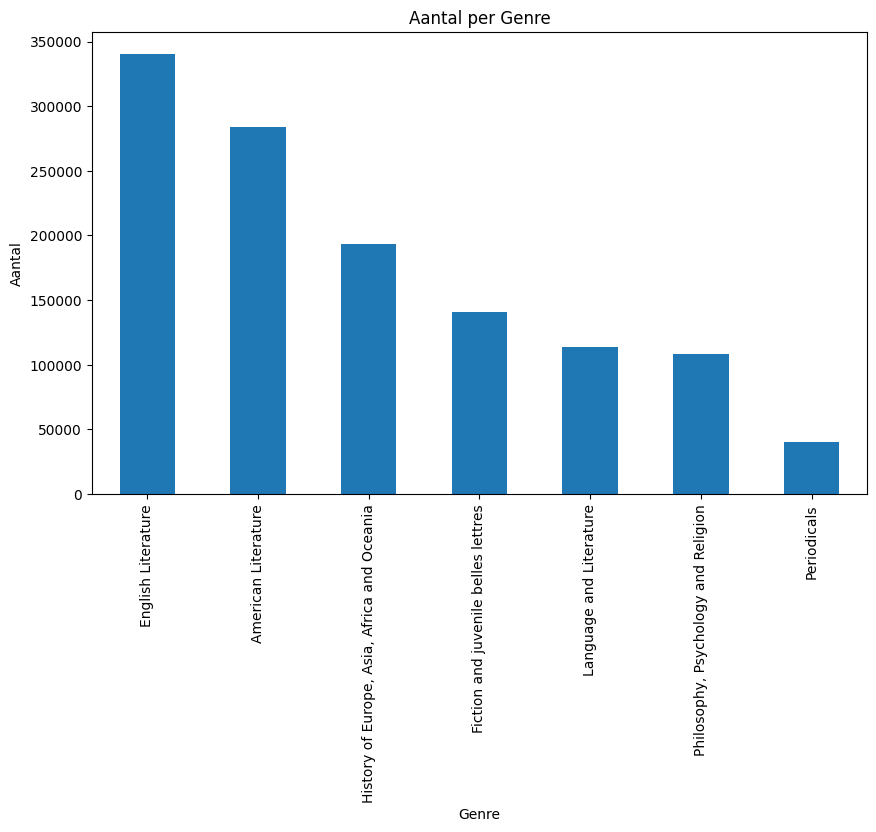

In [10]:
genre_counts = df_train['main genre'].value_counts()

plt.figure(figsize=(10,6))
genre_counts.plot(kind='bar')

plt.title('Aantal per Genre')
plt.xlabel('Genre')
plt.ylabel('Aantal')
plt.xticks(rotation=90)
plt.show()

Nu wil ik nog weten hoe lang de stukken tekst zijn.

In [11]:
text_lengths = df_train['txt'].str.len()
print(text_lengths.min())
print(text_lengths.max())

3
7146


# Data Preparation

[[ go back to the top ]](#Table-of-contents)

---

In [12]:
label_encoder = LabelEncoder()
df_train['genre_nr'] = label_encoder.fit_transform(df_train['main genre'])
df_train.head()

,usage,main genre,title,samplenumber,txt,genre_nr
0,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",600,journey more terrible than that of the ideal p...,0
1,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",1200,great struggle for freedom but a soldier of th...,0
2,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",1800,says overrun with superstition on one occasion...,0
3,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",2400,practice of swearing although previously he te...,0
4,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",3000,all manner of uncleanness he would laugh at al...,0


In [13]:
df_test['genre_nr'] = label_encoder.fit_transform(df_test['main genre'])
df_val['genre_nr'] = label_encoder.fit_transform(df_val['main genre'])

In [14]:
print(df_train['genre_nr'].unique())
print(df_train['main genre'].unique())

[0 2 5 1 6 3 4]
['American Literature' 'Fiction and juvenile belles lettres' 'Periodicals'
 'English Literature' 'Philosophy, Psychology and Religion'
 'History of Europe, Asia, Africa and Oceania' 'Language and Literature']


Dan gaan we de data tokenizen of ook wel dat we elk woord gaan vervangen door een unieke int. En dit doen we uiteraard voor alle 3 de datasets.

In [15]:
tokenizer_train = Tokenizer(num_words=10000)
tokenizer_train.fit_on_texts(df_train['txt'])
tokenizer_train.word_index

{'the': 1,
 'and': 2,
 'of': 3,
 'to': 4,
 'a': 5,
 'in': 6,
 'i': 7,
 'that': 8,
 'he': 9,
 'was': 10,
 'it': 11,
 'his': 12,
 'with': 13,
 'as': 14,
 'for': 15,
 'is': 16,
 'you': 17,
 'had': 18,
 'her': 19,
 'but': 20,
 'not': 21,
 'at': 22,
 'on': 23,
 'be': 24,
 'she': 25,
 'by': 26,
 'have': 27,
 'him': 28,
 'which': 29,
 'they': 30,
 'this': 31,
 'from': 32,
 'all': 33,
 'my': 34,
 'were': 35,
 'so': 36,
 'me': 37,
 'or': 38,
 'we': 39,
 'one': 40,
 'said': 41,
 'an': 42,
 'are': 43,
 'their': 44,
 'there': 45,
 'no': 46,
 'who': 47,
 'when': 48,
 'if': 49,
 'them': 50,
 'would': 51,
 'been': 52,
 'what': 53,
 'will': 54,
 'out': 55,
 'up': 56,
 'then': 57,
 'do': 58,
 'more': 59,
 'now': 60,
 'into': 61,
 'could': 62,
 'man': 63,
 'its': 64,
 'your': 65,
 'some': 66,
 'very': 67,
 'time': 68,
 'like': 69,
 'has': 70,
 'our': 71,
 'than': 72,
 'about': 73,
 'upon': 74,
 'little': 75,
 'did': 76,
 'well': 77,
 'only': 78,
 'see': 79,
 'any': 80,
 'other': 81,
 'before': 82,
 'aft

In [16]:
tokenizer_test = Tokenizer(num_words=10000)
tokenizer_test.fit_on_texts(df_test['txt'])
tokenizer_test.word_index

{'the': 1,
 'and': 2,
 'of': 3,
 'to': 4,
 'a': 5,
 'in': 6,
 'i': 7,
 'that': 8,
 'he': 9,
 'was': 10,
 'it': 11,
 'his': 12,
 'with': 13,
 'for': 14,
 'as': 15,
 'you': 16,
 'had': 17,
 'is': 18,
 'her': 19,
 'but': 20,
 'not': 21,
 'at': 22,
 'on': 23,
 'be': 24,
 'she': 25,
 'by': 26,
 'him': 27,
 'have': 28,
 'they': 29,
 'which': 30,
 'this': 31,
 'all': 32,
 'from': 33,
 'my': 34,
 'were': 35,
 'so': 36,
 'me': 37,
 'one': 38,
 'we': 39,
 'said': 40,
 'or': 41,
 'there': 42,
 'no': 43,
 'their': 44,
 'an': 45,
 'are': 46,
 'if': 47,
 'would': 48,
 'when': 49,
 'who': 50,
 'them': 51,
 'what': 52,
 'been': 53,
 'will': 54,
 'out': 55,
 'up': 56,
 'then': 57,
 'more': 58,
 'do': 59,
 'now': 60,
 'could': 61,
 'into': 62,
 'your': 63,
 'its': 64,
 'man': 65,
 'some': 66,
 'very': 67,
 'time': 68,
 'little': 69,
 'like': 70,
 'has': 71,
 'about': 72,
 'than': 73,
 'upon': 74,
 'did': 75,
 'well': 76,
 'our': 77,
 'only': 78,
 'see': 79,
 'any': 80,
 'other': 81,
 'before': 82,
 'goo

In [17]:
tokenizer_val = Tokenizer(num_words=10000)
tokenizer_val.fit_on_texts(df_val['txt'])
tokenizer_val.word_index

{'the': 1,
 'and': 2,
 'of': 3,
 'to': 4,
 'a': 5,
 'in': 6,
 'i': 7,
 'that': 8,
 'he': 9,
 'was': 10,
 'it': 11,
 'his': 12,
 'with': 13,
 'for': 14,
 'as': 15,
 'you': 16,
 'is': 17,
 'had': 18,
 'her': 19,
 'not': 20,
 'but': 21,
 'at': 22,
 'on': 23,
 'be': 24,
 'she': 25,
 'by': 26,
 'have': 27,
 'him': 28,
 'they': 29,
 'which': 30,
 'this': 31,
 'from': 32,
 'all': 33,
 'my': 34,
 'were': 35,
 'so': 36,
 'we': 37,
 'me': 38,
 'one': 39,
 'said': 40,
 'or': 41,
 'are': 42,
 'an': 43,
 'their': 44,
 'there': 45,
 'no': 46,
 'if': 47,
 'when': 48,
 'would': 49,
 'them': 50,
 'who': 51,
 'been': 52,
 'what': 53,
 'will': 54,
 'out': 55,
 'up': 56,
 'then': 57,
 'do': 58,
 'more': 59,
 'now': 60,
 'could': 61,
 'into': 62,
 'your': 63,
 'its': 64,
 'man': 65,
 'some': 66,
 'very': 67,
 'has': 68,
 'time': 69,
 'like': 70,
 'our': 71,
 'little': 72,
 'about': 73,
 'than': 74,
 'upon': 75,
 'did': 76,
 'well': 77,
 'only': 78,
 'any': 79,
 'see': 80,
 'other': 81,
 'before': 82,
 'aft

Daarna gaan we de teksten omzetten naar sequences, ook weer voor alle 3 de datasets

In [18]:
sequences_train = tokenizer_train.texts_to_sequences(df_train['txt'])
sequences_train[:5]

KeyboardInterrupt: 

In [19]:
sequences_test = tokenizer_test.texts_to_sequences(df_test['txt'])
sequences_test[:5]

[[11,
  3302,
  4,
  24,
  34,
  192,
  434,
  8,
  694,
  56,
  108,
  2,
  117,
  52,
  16,
  28,
  4,
  117,
  1,
  65,
  3176,
  6,
  580,
  49,
  9,
  17,
  89,
  113,
  236,
  1962,
  9,
  745,
  19,
  140,
  1,
  38,
  30,
  10,
  2582,
  4,
  27,
  4,
  12,
  563,
  2,
  730,
  4441,
  11,
  6,
  12,
  112,
  1790,
  37,
  47,
  7,
  544,
  9,
  40,
  1,
  360,
  18,
  428,
  71,
  53,
  689,
  23,
  34,
  3535,
  14,
  1,
  143,
  202,
  224,
  2,
  34,
  1943,
  473,
  345,
  55,
  25,
  178,
  22,
  27,
  3636,
  25,
  10,
  471,
  889,
  536,
  2,
  19,
  150,
  751,
  1945,
  3,
  1,
  1692,
  2,
  2769,
  3,
  114,
  20,
  25,
  139,
  17,
  465,
  137,
  2,
  1,
  3093,
  3,
  4672,
  525,
  17,
  207,
  44,
  262,
  14,
  19,
  52,
  18,
  1,
  287,
  25,
  196,
  28,
  1,
  3873,
  53,
  188,
  170,
  16,
  9,
  6608,
  2,
  2526,
  14,
  5,
  223,
  82,
  9,
  40,
  210,
  95,
  90,
  42,
  18,
  45,
  839,
  4450,
  2,
  8,
  18,
  8,
  39,
  92,
  168,
  1,
  380,
 

In [20]:
sequences_val = tokenizer_val.texts_to_sequences(df_val['txt'])
sequences_val[:5]

[[159,
  336,
  9,
  10,
  93,
  5,
  2333,
  573,
  8182,
  11,
  10,
  6,
  8,
  15,
  39,
  3,
  1,
  509,
  3,
  1376,
  9,
  591,
  62,
  5786,
  14,
  1,
  3606,
  3,
  579,
  177,
  443,
  5257,
  3,
  349,
  23,
  1044,
  858,
  6,
  158,
  1036,
  347,
  106,
  11,
  10,
  12,
  1016,
  4,
  4264,
  1,
  344,
  3,
  5,
  7662,
  3,
  6,
  31,
  244,
  31,
  2754,
  411,
  1,
  3856,
  14,
  5,
  412,
  26,
  3127,
  219,
  8704,
  9,
  603,
  6,
  158,
  1036,
  23,
  816,
  217,
  635,
  6,
  8,
  344,
  259,
  79,
  279,
  54,
  178,
  5,
  1229,
  484,
  3,
  1,
  7969,
  3,
  1207,
  2240,
  9,
  635,
  22,
  5,
  69,
  48,
  790,
  687,
  35,
  738,
  4,
  6896,
  113,
  5,
  284,
  3,
  122,
  3,
  1,
  1787,
  1886,
  3,
  1,
  102,
  9428,
  631,
  2,
  270,
  2,
  37,
  27,
  43,
  1259,
  1698,
  3,
  1,
  423,
  6,
  30,
  1,
  1852,
  1787,
  108,
  1371,
  1,
  1061,
  3,
  6,
  1,
  3,
  1759,
  1325,
  99,
  13,
  38,
  9,
  97,
  40,
  1447,
  23,
  12,
  892,


En vullen we alle woorden aan naar 600 woorden, zoals in de opdracht stond.

Ik had telkens een kernel crash. Hierom heb ik chatgpt om hulp gevraagd hoe ik de dataset in batches kon runnen.

In [21]:
# Stel het totale aantal samples en de gewenste batchgrootte in
max_features = int(len(sequences_train)/3) # We nemen een stukje van de dataset (dit is een stukje trail en error geweest. je wil natuurlijk zoveel mogelijk data wel gebruiken)
batch_size = 100 # Batchgrootte voor verwerking
maxlen = 600  # Maximale lengte voor pad_sequences

# Selecteer een subset van de dataset
subset_sequences = sequences_train[:max_features]  # Pak de eerste helft van de dataset

# Vooraf een array aanmaken om batches in op te slaan (max_features aantal samples)
padded_sequence_train = np.zeros((max_features, maxlen))

# Verwerk de subset in batches
for i in range(0, max_features, batch_size):
    end_idx = min(i + batch_size, max_features)
    batch_sequences = subset_sequences[i:end_idx]

    # Pas padding toe op de batch
    padded_batch = pad_sequences(batch_sequences, maxlen=maxlen)

    # Plaats de gepadde batch in de hoofdarray
    padded_sequence_train[i:end_idx] = padded_batch

    print(f"Batch {i // batch_size + 1}/{(max_features // batch_size) + 1} verwerkt")

# Eerste sample van de volledige gepadde subset weergeven
print(padded_sequence_train[0])

Batch 1/4068 verwerkt
Batch 2/4068 verwerkt
Batch 3/4068 verwerkt
Batch 4/4068 verwerkt
Batch 5/4068 verwerkt
Batch 6/4068 verwerkt
Batch 7/4068 verwerkt
Batch 8/4068 verwerkt
Batch 9/4068 verwerkt
Batch 10/4068 verwerkt
Batch 11/4068 verwerkt
Batch 12/4068 verwerkt
Batch 13/4068 verwerkt
Batch 14/4068 verwerkt
Batch 15/4068 verwerkt
Batch 16/4068 verwerkt
Batch 17/4068 verwerkt
Batch 18/4068 verwerkt
Batch 19/4068 verwerkt
Batch 20/4068 verwerkt
Batch 21/4068 verwerkt
Batch 22/4068 verwerkt
Batch 23/4068 verwerkt
Batch 24/4068 verwerkt
Batch 25/4068 verwerkt
Batch 26/4068 verwerkt
Batch 27/4068 verwerkt
Batch 28/4068 verwerkt
Batch 29/4068 verwerkt
Batch 30/4068 verwerkt
Batch 31/4068 verwerkt
Batch 32/4068 verwerkt
Batch 33/4068 verwerkt
Batch 34/4068 verwerkt
Batch 35/4068 verwerkt
Batch 36/4068 verwerkt
Batch 37/4068 verwerkt
Batch 38/4068 verwerkt
Batch 39/4068 verwerkt
Batch 40/4068 verwerkt
Batch 41/4068 verwerkt
Batch 42/4068 verwerkt
Batch 43/4068 verwerkt
Batch 44/4068 verwer

In [22]:
# Stel het totale aantal samples en de gewenste batchgrootte in
max_features = len(sequences_test) # We nemen de hele dataset (dit is een stukje trail en error geweest. je wil natuurlijk zoveel mogelijk data wel gebruiken
batch_size = 100 # Batchgrootte voor verwerking
maxlen = 600  # Maximale lengte voor pad_sequences

# Selecteer een subset van de dataset
subset_sequences = sequences_test[:max_features]  # Pak de eerste helft van de dataset

# Vooraf een array aanmaken om batches in op te slaan (max_features aantal samples)
padded_sequence_test = np.zeros((max_features, maxlen))

# Verwerk de subset in batches
for i in range(0, max_features, batch_size):
    end_idx = min(i + batch_size, max_features)
    batch_sequences = subset_sequences[i:end_idx]

    # Pas padding toe op de batch
    padded_batch = pad_sequences(batch_sequences, maxlen=maxlen)

    # Plaats de gepadde batch in de hoofdarray
    padded_sequence_test[i:end_idx] = padded_batch

    print(f"Batch {i // batch_size + 1}/{(max_features // batch_size) + 1} verwerkt")

# Eerste sample van de volledige gepadde subset weergeven
print(padded_sequence_test[0])

Batch 1/1880 verwerkt
Batch 2/1880 verwerkt
Batch 3/1880 verwerkt
Batch 4/1880 verwerkt
Batch 5/1880 verwerkt
Batch 6/1880 verwerkt
Batch 7/1880 verwerkt
Batch 8/1880 verwerkt
Batch 9/1880 verwerkt
Batch 10/1880 verwerkt
Batch 11/1880 verwerkt
Batch 12/1880 verwerkt
Batch 13/1880 verwerkt
Batch 14/1880 verwerkt
Batch 15/1880 verwerkt
Batch 16/1880 verwerkt
Batch 17/1880 verwerkt
Batch 18/1880 verwerkt
Batch 19/1880 verwerkt
Batch 20/1880 verwerkt
Batch 21/1880 verwerkt
Batch 22/1880 verwerkt
Batch 23/1880 verwerkt
Batch 24/1880 verwerkt
Batch 25/1880 verwerkt
Batch 26/1880 verwerkt
Batch 27/1880 verwerkt
Batch 28/1880 verwerkt
Batch 29/1880 verwerkt
Batch 30/1880 verwerkt
Batch 31/1880 verwerkt
Batch 32/1880 verwerkt
Batch 33/1880 verwerkt
Batch 34/1880 verwerkt
Batch 35/1880 verwerkt
Batch 36/1880 verwerkt
Batch 37/1880 verwerkt
Batch 38/1880 verwerkt
Batch 39/1880 verwerkt
Batch 40/1880 verwerkt
Batch 41/1880 verwerkt
Batch 42/1880 verwerkt
Batch 43/1880 verwerkt
Batch 44/1880 verwer

In [23]:
# Stel het totale aantal samples en de gewenste batchgrootte in
max_features = int(len(sequences_val)/2) # We nemen een stukje van de dataset (dit is een stukje trail en error geweest. je wil natuurlijk zoveel mogelijk data wel gebruiken
batch_size = 100 # Batchgrootte voor verwerking
maxlen = 600  # Maximale lengte voor pad_sequences

# Selecteer een subset van de dataset
subset_sequences = sequences_val[:max_features]  # Pak de eerste helft van de dataset

# Vooraf een array aanmaken om batches in op te slaan (max_features aantal samples)
padded_sequence_val = np.zeros((max_features, maxlen))

# Verwerk de subset in batches
for i in range(0, max_features, batch_size):
    end_idx = min(i + batch_size, max_features)
    batch_sequences = subset_sequences[i:end_idx]

    # Pas padding toe op de batch
    padded_batch = pad_sequences(batch_sequences, maxlen=maxlen)

    # Plaats de gepadde batch in de hoofdarray
    padded_sequence_val[i:end_idx] = padded_batch

    print(f"Batch {i // batch_size + 1}/{(max_features // batch_size) + 1} verwerkt")

# Eerste sample van de volledige gepadde subset weergeven
print(padded_sequence_val[0])

Batch 1/1691 verwerkt
Batch 2/1691 verwerkt
Batch 3/1691 verwerkt
Batch 4/1691 verwerkt
Batch 5/1691 verwerkt
Batch 6/1691 verwerkt
Batch 7/1691 verwerkt
Batch 8/1691 verwerkt
Batch 9/1691 verwerkt
Batch 10/1691 verwerkt
Batch 11/1691 verwerkt
Batch 12/1691 verwerkt
Batch 13/1691 verwerkt
Batch 14/1691 verwerkt
Batch 15/1691 verwerkt
Batch 16/1691 verwerkt
Batch 17/1691 verwerkt
Batch 18/1691 verwerkt
Batch 19/1691 verwerkt
Batch 20/1691 verwerkt
Batch 21/1691 verwerkt
Batch 22/1691 verwerkt
Batch 23/1691 verwerkt
Batch 24/1691 verwerkt
Batch 25/1691 verwerkt
Batch 26/1691 verwerkt
Batch 27/1691 verwerkt
Batch 28/1691 verwerkt
Batch 29/1691 verwerkt
Batch 30/1691 verwerkt
Batch 31/1691 verwerkt
Batch 32/1691 verwerkt
Batch 33/1691 verwerkt
Batch 34/1691 verwerkt
Batch 35/1691 verwerkt
Batch 36/1691 verwerkt
Batch 37/1691 verwerkt
Batch 38/1691 verwerkt
Batch 39/1691 verwerkt
Batch 40/1691 verwerkt
Batch 41/1691 verwerkt
Batch 42/1691 verwerkt
Batch 43/1691 verwerkt
Batch 44/1691 verwer

In [24]:
#download glove. Pas het path aan en run de onderstaande code
import os
import numpy as np

embeddings_index = {}
f = open(os.path.join('dataset/glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print(embeddings_index['the'])  #voorbeeld van een willekeurig woord

Found 400000 word vectors.
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0

In [25]:
# Stap 1: Definieer max_features
max_features = 10000  # Aantal woorden dat we willen gebruiken

# Stap 2: Initialiseer de embedding_matrix
embedding_dim = 100
embedding_matrix_train = np.zeros((max_features, embedding_dim))  # Initialiseren met 0

# Stap 3: Vul de embedding_matrix
for word, i in tokenizer_train.word_index.items():
    if i < max_features:  # Zorg ervoor dat we niet buiten de index gaan
        embedding_vector = embeddings_index.get(word)  # Haal de vector op
        if embedding_vector is not None:  # Als het woord gevonden is
            embedding_matrix_train[i] = embedding_vector  # Vul de matrix

# Toon een voorbeeld van een vector
print(embedding_matrix_train[3])  # Voorbeeld van de vector voor het woord met index 3

[-0.1529     -0.24279     0.89837003  0.16996001  0.53516001  0.48784
 -0.58825999 -0.17982    -1.35810006  0.42541     0.15377     0.24214999
  0.13474     0.41192999  0.67043    -0.56418002  0.42985001 -0.012183
 -0.11677     0.31781     0.054177   -0.054273    0.35516    -0.30241001
  0.31434    -0.33846     0.71714997 -0.26855001 -0.15837    -0.47466999
  0.051581   -0.33252001  0.15003    -0.12989999 -0.54617    -0.37843001
  0.64261001  0.82187003 -0.080006    0.078479   -0.96976    -0.57740998
  0.56490999 -0.39873001 -0.057099    0.19743     0.065706   -0.48091999
 -0.20125    -0.40834001  0.39456001 -0.02642    -0.11838     1.01199996
 -0.53171003 -2.74740005 -0.042981   -0.74848998  1.75740004  0.59085
  0.04885     0.78267002  0.38497001  0.42096999  0.67882001  0.10337
  0.63279998 -0.026595    0.58647001 -0.44332001  0.33057001 -0.12022
 -0.55645001  0.073611    0.20915     0.43395001 -0.012761    0.089874
 -1.79910004  0.084808    0.77112001  0.63104999 -0.90684998  0.603

In [26]:
# Stap 1: Definieer max_features
max_features = 10000  # Aantal woorden dat we willen gebruiken

# Stap 2: Initialiseer de embedding_matrix
embedding_dim = 100
embedding_matrix_test = np.zeros((max_features, embedding_dim))  # Initialiseren met 0

# Stap 3: Vul de embedding_matrix
for word, i in tokenizer_test.word_index.items():
    if i < max_features:  # Zorg ervoor dat we niet buiten de index gaan
        embedding_vector = embeddings_index.get(word)  # Haal de vector op
        if embedding_vector is not None:  # Als het woord gevonden is
            embedding_matrix_test[i] = embedding_vector  # Vul de matrix

# Toon een voorbeeld van een vector
print(embedding_matrix_test[3])  # Voorbeeld van de vector voor het woord met index 3

[-0.1529     -0.24279     0.89837003  0.16996001  0.53516001  0.48784
 -0.58825999 -0.17982    -1.35810006  0.42541     0.15377     0.24214999
  0.13474     0.41192999  0.67043    -0.56418002  0.42985001 -0.012183
 -0.11677     0.31781     0.054177   -0.054273    0.35516    -0.30241001
  0.31434    -0.33846     0.71714997 -0.26855001 -0.15837    -0.47466999
  0.051581   -0.33252001  0.15003    -0.12989999 -0.54617    -0.37843001
  0.64261001  0.82187003 -0.080006    0.078479   -0.96976    -0.57740998
  0.56490999 -0.39873001 -0.057099    0.19743     0.065706   -0.48091999
 -0.20125    -0.40834001  0.39456001 -0.02642    -0.11838     1.01199996
 -0.53171003 -2.74740005 -0.042981   -0.74848998  1.75740004  0.59085
  0.04885     0.78267002  0.38497001  0.42096999  0.67882001  0.10337
  0.63279998 -0.026595    0.58647001 -0.44332001  0.33057001 -0.12022
 -0.55645001  0.073611    0.20915     0.43395001 -0.012761    0.089874
 -1.79910004  0.084808    0.77112001  0.63104999 -0.90684998  0.603

In [27]:
# Stap 1: Definieer max_features
max_features = 10000  # Aantal woorden dat we willen gebruiken

# Stap 2: Initialiseer de embedding_matrix
embedding_dim = 100
embedding_matrix_val = np.zeros((max_features, embedding_dim))  # Initialiseren met 0

# Stap 3: Vul de embedding_matrix
for word, i in tokenizer_val.word_index.items():
    if i < max_features:  # Zorg ervoor dat we niet buiten de index gaan
        embedding_vector = embeddings_index.get(word)  # Haal de vector op
        if embedding_vector is not None:  # Als het woord gevonden is
            embedding_matrix_val[i] = embedding_vector  # Vul de matrix

# Toon een voorbeeld van een vector
print(embedding_matrix_val[3])  # Voorbeeld van de vector voor het woord met index 3

[-0.1529     -0.24279     0.89837003  0.16996001  0.53516001  0.48784
 -0.58825999 -0.17982    -1.35810006  0.42541     0.15377     0.24214999
  0.13474     0.41192999  0.67043    -0.56418002  0.42985001 -0.012183
 -0.11677     0.31781     0.054177   -0.054273    0.35516    -0.30241001
  0.31434    -0.33846     0.71714997 -0.26855001 -0.15837    -0.47466999
  0.051581   -0.33252001  0.15003    -0.12989999 -0.54617    -0.37843001
  0.64261001  0.82187003 -0.080006    0.078479   -0.96976    -0.57740998
  0.56490999 -0.39873001 -0.057099    0.19743     0.065706   -0.48091999
 -0.20125    -0.40834001  0.39456001 -0.02642    -0.11838     1.01199996
 -0.53171003 -2.74740005 -0.042981   -0.74848998  1.75740004  0.59085
  0.04885     0.78267002  0.38497001  0.42096999  0.67882001  0.10337
  0.63279998 -0.026595    0.58647001 -0.44332001  0.33057001 -0.12022
 -0.55645001  0.073611    0.20915     0.43395001 -0.012761    0.089874
 -1.79910004  0.084808    0.77112001  0.63104999 -0.90684998  0.603

# Modeling

[[ go back to the top ]](#Table-of-contents)

*Korte uitleg wat voor model je gebruikt en waarom*

---

### Experiment 1

We gaan eerst een simpel model maken om te zien wat daar uit komt.

In [85]:
model = tf.keras.Sequential([
    layers.Embedding(input_dim=max_features, output_dim=embedding_dim,
                              input_length=600, weights=[embedding_matrix_train], trainable=False),  # Gebruik de embedding_matrix
    layers.LSTM(32),
    layers.Dense(7, activation='softmax')  # Output layer met meerdere neurons
])

c:\Users\iris_\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


De padded sequence train en df_train hadden natuurlijk nog niet dezelfde lengte. dus dat moeten we nog even aanpassen voordat we het in een model kunnen stoppen.

In [86]:
len(padded_sequence_train)

406708

In [87]:
len(df_train)

1220126

In [88]:
df_train_size = int(len(df_train)/3)
df_train = df_train[:df_train_size]
print(len(df_train))

406708


In [ ]:
df_val_size = int(len(df_val)/2)
df_val = df_val[:df_val_size]

In [97]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(padded_sequence_train, df_train['genre_nr'], epochs=3, validation_split=0.2)

Epoch 1/3
10168/10168 ━━━━━━━━━━━━━━━━━━━━ 1192s 117ms/step - accuracy: 0.6941 - loss: 0.8556 - val_accuracy: 0.6693 - val_loss: 0.9360
Epoch 2/3
10168/10168 ━━━━━━━━━━━━━━━━━━━━ 1211s 119ms/step - accuracy: 0.7049 - loss: 0.8295 - val_accuracy: 0.6714 - val_loss: 0.9461
Epoch 3/3
10168/10168 ━━━━━━━━━━━━━━━━━━━━ 1174s 115ms/step - accuracy: 0.7115 - loss: 0.8143 - val_accuracy: 0.6714 - val_loss: 0.9467


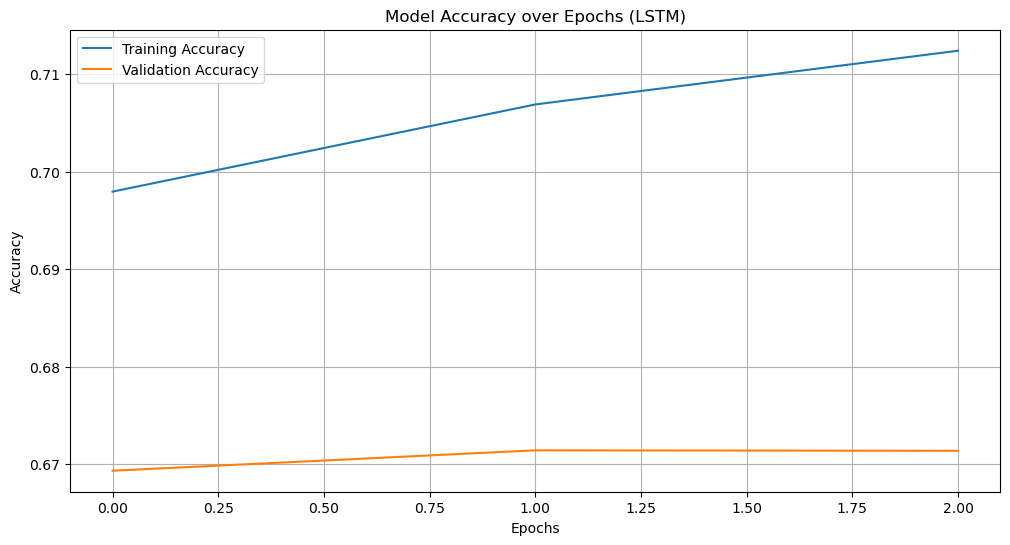

In [98]:
#plot de accuracy en validated accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

De accuracy is oké maar kan nog wel hoger. En de loss is vrij hoog. We moeten dus wat anders gaan proberen

### experiment 2

Nu gaan we GRU uittesten, maar wel met 2 lagen en een dropout.

In [30]:
model = tf.keras.Sequential([
    layers.Embedding(input_dim=max_features, output_dim=embedding_dim,
                              input_length=600, weights=[embedding_matrix_train], trainable=False),
    layers.GRU(32, return_sequences=True),
    layers.GRU(64),
    layers.Dense(7, activation='softmax')
])

c:\Users\iris_\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [31]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(padded_sequence_train, df_train['genre_nr'], epochs=3, validation_split=0.2)

Epoch 1/3
  190/10168 ━━━━━━━━━━━━━━━━━━━━ 33:37 202ms/step - accuracy: 0.2768 - loss: 1.7546

In [ ]:
#plot de accuracy en validated accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Experiment 3

Ook testen we een model met bidirectional GRU layers

In [ ]:
model = tf.keras.Sequential([
    layers.Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=600, weights=[embedding_matrix_train], trainable=False),
    layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    layers.Bidirectional(layers.GRU(32)),
    layers.Dense(64, activation='relu'),
    layers.Dense(7, activation='softmax')
])

# Evaluation 

[[ go back to the top ]](#Table-of-contents)

*Doormiddel van visualisaties laten zien waarom het wel of niet werkt en benoem de vervolgstappen voor vervolg onderzoek*

---

# Reproducibility

[[ go back to the top ]](#Table-of-contents)

*Als je notebook niet nagemaakt kan worden is het een slecht notebook, wat je hier kan benoemen is dat er een requirements.txt is met de versies en een compacte versie van je code in 1 codeblock*

---

Je kan dit ook nog toevoegen:

<div class="alert alert-block alert-success"><b>Success:</b> This alert box indicates a successful or positive action.</div>

<div class="alert alert-block alert-warning"><b>Example:</b> Use yellow boxes for examples that are not inside code cells, or use for mathematical formulas if needed. Typically also used to display warning messages.</div>

<div class="alert alert-block alert-info"><b>Tip:</b> Use blue boxes (alert-info) for tips and notes.</div>

<div class="alert alert-block alert-danger"><b>Danger:</b> This alert box indicates a dangerous or potentially negative action.</div>

Zo'n markdown block is gewoon HTML-code